# GLMNET

## loading data

In [5]:
from data import Data
import tomllib

with open("config.toml", "rb") as file:
    config = tomllib.load(file)
    
data = Data(config)

Reading data...


## Setup for GLMNET

Note: the amount of data in the subset might differ from the amount requested in `data.get_subset()`, when you request more data than the given number of labels can provide.

Note: the label distribution plots are not yet in the same order.

shape of subset: (1888, 9)


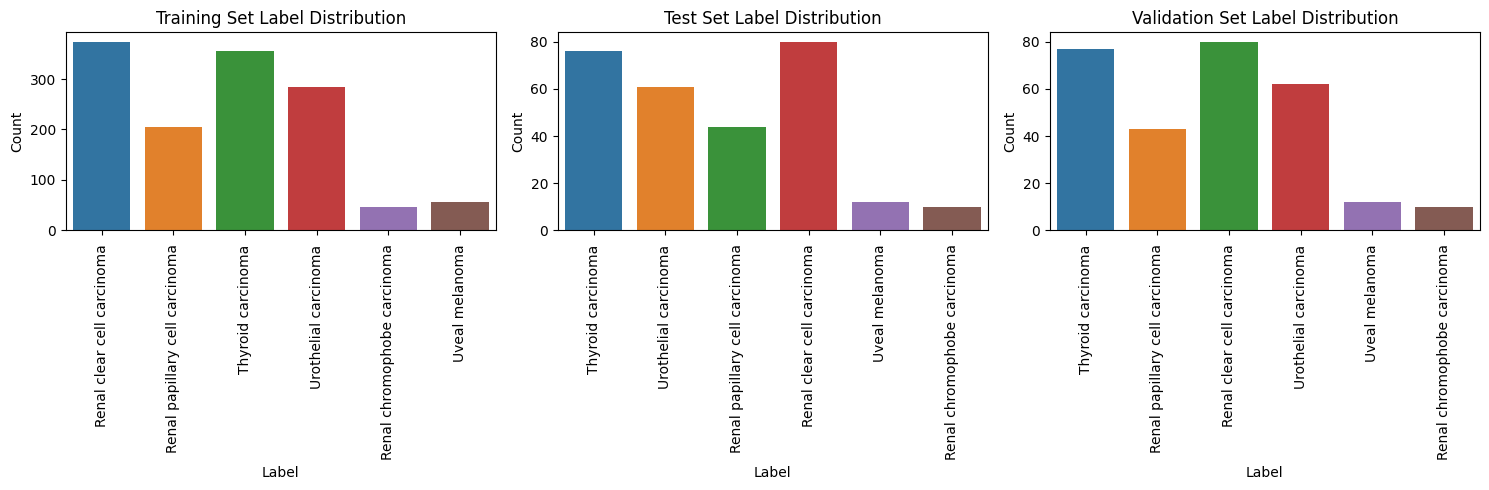

In [13]:
from ml.glm import GLM
glm = GLM(data)

mm_with_tt = data.get_mm_with_tt()

subset = data.get_subset(mm_with_tt, n_rows=2000, n_cols=10, n_labels=6)
subset = subset.set_index("samples")

print("shape of subset:", subset.shape)

train, test, val = data.get_train_test_val(
    train_size=0.7,
    test_size=0.15,
    val_size=0.15,
    data=subset
)

glm.plot_label_distribution(train, test, val)

## Run GLMNET

In [14]:
glm.fit_glm(train)

Doing cv.glmnet...
Doing glmnet...


R[write to console]: Error in matrix(fit$a0[seq(lmu * nc)], nc, lmu, dimnames = list(classnames,  : 
  length of 'dimnames' [2] not equal to array extent

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: from glmnet C++ code (error code -1); Convergence for 1th lambda value not reached after maxit=1000000 iterations; solutions for larger lambdas returned 



RRuntimeError: Error in matrix(fit$a0[seq(lmu * nc)], nc, lmu, dimnames = list(classnames,  : 
  length of 'dimnames' [2] not equal to array extent
